In [3]:
import os
import glob

from tqdm import tqdm

import netCDF4 as nc
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import sys
import platform
import importlib

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')

import HydroAI.SMAP as hSMAP
importlib.reload(hSMAP);

In [4]:
def list_nc_files(base_dir):
    # This function will return a list of all .nc files in the directory and its subdirectories
    nc_files = []
    # Walk through the directory
    for root, dirs, files in os.walk(base_dir):
        # Filter for .nc files
        for file in files:
            if file.endswith(".nc4"):
                full_path = os.path.join(root, file)
                nc_files.append(full_path)
    
    nc_files.sort() 
    return nc_files

base_dir = "/Users/hyunglokkim/cpuserver_data/CYGNSS/L1_V21"
nc_file_list = list_nc_files(base_dir)

In [208]:
ref_lon, ref_lat = hSMAP.get_e2grid(cpuserver_data_FP, 'SPL3SMP.006')
data_count = np.zeros_like(ref_lat, dtype=int)
# Flatten the reference arrays and stack them as [latitude, longitude]
ref_points = np.column_stack((ref_lat.flatten(), ref_lon.flatten()))
tree = cKDTree(ref_points)

In [209]:
# Load the first NetCDF file
for i, file_name in tqdm(enumerate(nc_file_list[:1000]), total=len(nc_file_list[:1000]), desc="Processing Files"):
    dataset = nc.Dataset(file_name)
    # Assume the latitude and longitude variable names are known
    sp_lat = dataset.variables['sp_lat'][:].flatten().compressed()
    sp_lon = dataset.variables['sp_lon'][:].flatten().compressed() - 180
    # Stack satellite latitudes and longitudes
    sat_points = np.column_stack((sp_lat, sp_lon))
    _, indices = tree.query(sat_points)
    
    rows, cols = np.unravel_index(indices, ref_lat.shape)

    np.add.at(data_count, (rows, cols), 1)

Processing Files: 100%|█████████████████████████████████████| 1000/1000 [02:46<00:00,  6.02it/s]


In [232]:
# Initialize a dictionary to hold lists of sp_inc_angle values for each grid cell
from collections import defaultdict
angle_data = defaultdict(list)

for i, file_name in tqdm(enumerate(nc_file_list[:1000]), total=len(nc_file_list[:1000]), desc="Processing Files"):
    dataset = nc.Dataset(file_name)
    # Extract latitude, longitude, and incidence angle
    sp_lat = dataset.variables['sp_lat'][:].flatten().compressed()
    sp_lon = dataset.variables['sp_lon'][:].flatten().compressed() - 180
    sp_inc_angle = dataset.variables['sp_inc_angle'][:].flatten().compressed()

    # Stack satellite latitudes and longitudes
    sat_points = np.column_stack((sp_lat, sp_lon))
    _, indices = tree.query(sat_points)

    # Get the row and column indices in the reference grid
    rows, cols = np.unravel_index(indices, ref_lat.shape)

    # Store sp_inc_angle values in the dictionary
    for idx, angle in zip(indices, sp_inc_angle):
        angle_data[idx].append(angle)

Processing Files: 100%|███████████████████████████████████████| 300/300 [00:55<00:00,  5.42it/s]


In [216]:
mean_angles = {idx: np.mean(angles) for idx, angles in angle_data.items()}

(array([ 42.,  46.,  40., 113.,  64.,  59.,  72.,  38.,  13.,  35.]),
 array([ 4.43687296, 11.01006031, 17.58324814, 24.15643501, 30.72962189,
        37.30281067, 43.87599564, 50.44918442, 57.0223732 , 63.59555817,
        70.16874695]),
 <BarContainer object of 10 artists>)

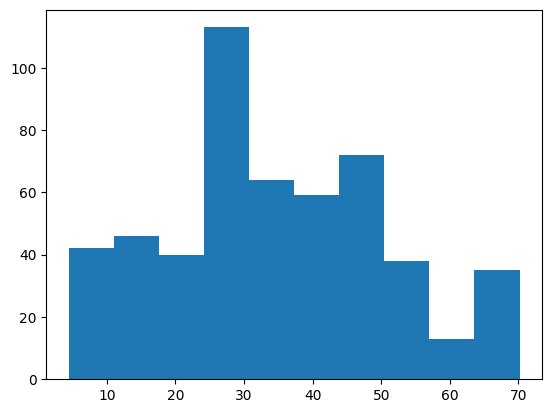

In [233]:
plt.hist(angle_data[97857])

TypeError: Image data of dtype object cannot be converted to float

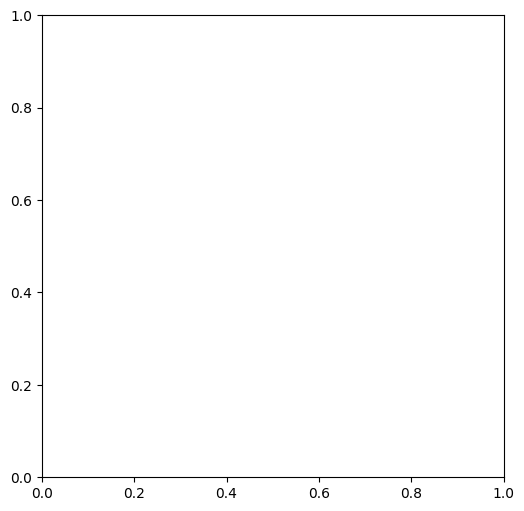

In [218]:
plt.figure(figsize=(10, 6))
#im = plt.imshow(data_count, cmap='viridis')
im = plt.imshow(mean_angles, cmap='viridis')
plt.colorbar(im)
plt.title("Visualization of Data Count")
plt.xlabel("Longitude Index")
plt.ylabel("Latitude Index")
plt.show()

In [ ]:
import numpy as np
import netCDF4 as nc
import os
from scipy.spatial import cKDTree
from multiprocessing import Pool

# Make sure you have imported or defined hSMAP.get_e2grid
import sys
import platform

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')
import HydroAI.SMAP as hSMAP

def list_nc_files(base_dir):
    nc_files = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".nc4"):
                full_path = os.path.join(root, file)
                nc_files.append(full_path)
    nc_files.sort()
    return nc_files

def process_file(args):
    file_name, ref_points = args
    dataset = nc.Dataset(file_name)
    sp_lat = dataset.variables['sp_lat'][:].flatten().compressed()
    sp_lon = dataset.variables['sp_lon'][:].flatten().compressed() - 180
    sat_points = np.column_stack((sp_lat, sp_lon))
    
    tree = cKDTree(ref_points)
    _, indices = tree.query(sat_points)
    
    # Assuming ref_lat and ref_lon are arranged in a two-dimensional grid
    rows, cols = np.unravel_index(indices, (len(ref_lat), len(ref_lon)))

    local_data_count = np.zeros((len(ref_lat), len(ref_lon)), dtype=int)
    np.add.at(local_data_count, (rows, cols), 1)
    return local_data_count

def reduce_data_counts(total, addition):
    total += addition
    return total

base_dir = "/Users/hyunglokkim/cpuserver_data/CYGNSS/L1_V21"
nc_file_list = list_nc_files(base_dir)
ref_lon, ref_lat = hSMAP.get_e2grid(cpuserver_data_FP, 'SPL3SMP.006')
ref_points = np.column_stack((ref_lat.flatten(), ref_lon.flatten()))

if __name__ == '__main__':
    
    with Pool() as pool:
        results = pool.map(process_file, [(file_name, ref_points) for file_name in nc_file_list])
        data_count = np.zeros_like(ref_lat, dtype=int)
        for result in results:
            data_count = reduce_data_counts(data_count, result)

    print("Data count grid:", data_count)

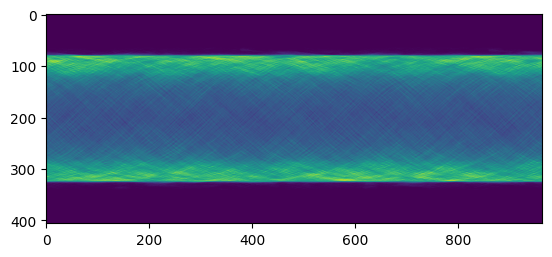

In [204]:
plt.imshow(data_count)